# Jane Street Market Prediction - Improved Solution

**Model Architecture**: AE-MLP + XGBoost Ensemble

**Key Improvements**:
- AE-MLP target optimization (resp_3 vs 5targets)
- XGBoost hyperparameter experiments
- Threshold optimization
- Comprehensive final comparison

## 1. Imports & Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os, gc
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import tensorflow as tf
tf.random.set_seed(2212)
import tensorflow.keras.backend as K
import tensorflow.keras.layers as layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Environment detection
IS_KAGGLE = os.path.exists('/kaggle/input')
if IS_KAGGLE:
    KAGGLE_INPUT_DIR = '/kaggle/input'
    KAGGLE_WORKING_DIR = '/kaggle/working'
    input_dirs = [d for d in os.listdir(KAGGLE_INPUT_DIR) 
                  if os.path.isdir(os.path.join(KAGGLE_INPUT_DIR, d))]
    if input_dirs:
        dataset_name = input_dirs[0]
        DATA_DIR = os.path.join(KAGGLE_INPUT_DIR, dataset_name)
        print(f"Kaggle environment detected. Dataset: {dataset_name}")
    else:
        DATA_DIR = KAGGLE_INPUT_DIR
    MODEL_DIR = KAGGLE_WORKING_DIR
    OUTPUT_DIR = KAGGLE_WORKING_DIR
    os.makedirs(os.path.join(OUTPUT_DIR, 'plots'), exist_ok=True)
else:
    DATA_DIR = '.'
    MODEL_DIR = '.'
    OUTPUT_DIR = '.'
    os.makedirs('plots', exist_ok=True)
    print("Local environment detected.")

# GPU detection
USE_GPU = len(tf.config.list_physical_devices('GPU')) > 0
print(f"GPU Available (TensorFlow): {USE_GPU}")

# XGBoost GPU configuration
XGB_GPU_AVAILABLE = False
XGB_TREE_METHOD = 'hist'
XGB_DEVICE = None

xgb_version = xgb.__version__
print(f"XGBoost version: {xgb_version}")

if USE_GPU:
    try:
        version_parts = xgb_version.split('.')
        major_version = int(version_parts[0])
        minor_version = int(version_parts[1]) if len(version_parts) > 1 else 0
        
        if major_version >= 3:
            XGB_TREE_METHOD = 'hist'
            XGB_DEVICE = 'cuda'
        elif major_version == 2 or (major_version == 1 and minor_version >= 6):
            XGB_TREE_METHOD = 'gpu_hist'
            XGB_DEVICE = None
        
        if XGB_TREE_METHOD in ['gpu_hist', 'hist'] and XGB_DEVICE != 'cpu':
            test_X = np.random.rand(100, 10).astype(np.float32)
            test_y = np.random.randint(0, 2, 100)
            test_params = {'n_estimators': 1, 'tree_method': XGB_TREE_METHOD, 'max_depth': 2}
            if XGB_DEVICE:
                test_params['device'] = XGB_DEVICE
            test_clf = xgb.XGBClassifier(**test_params, random_state=42)
            test_clf.fit(test_X, test_y)
            XGB_GPU_AVAILABLE = True
            print(f"XGBoost GPU test successful")
    except Exception as e:
        print(f"XGBoost GPU test failed, using CPU")
        XGB_TREE_METHOD = 'hist'
        XGB_DEVICE = None

print(f"XGBoost config: tree_method={XGB_TREE_METHOD}, device={XGB_DEVICE}")

2026-01-27 19:20:08.058167: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769541608.555085      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769541608.680603      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769541609.873772      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769541609.873812      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769541609.873814      55 computation_placer.cc:177] computation placer alr

Kaggle environment detected. Dataset: jane-street
GPU Available (TensorFlow): True
XGBoost version: 3.1.0
XGBoost GPU test successful
XGBoost config: tree_method=hist, device=cuda


## 2. Helper Functions

In [2]:
def weighted_average(a):
    """Weighted average with exponential weights (later folds get higher weight)"""
    w = []
    n = len(a)
    for j in range(1, n + 1):
        j = 2 if j == 1 else j
        w.append(1 / (2**(n + 1 - j)))
    return np.average(a, weights=w)

In [3]:
def utility_score(date, weight, resp, action):
    """Calculate competition utility score"""
    profit = weight * resp * action
    df = pd.DataFrame({'date': date, 'profit': profit})
    daily_profit = df.groupby('date')['profit'].sum()
    p_i = daily_profit.values
    
    sum_p = np.sum(p_i)
    sum_p_sq = np.sum(p_i ** 2)
    n_days = len(p_i)
    
    if sum_p_sq == 0:
        return 0.0
    
    t = (sum_p / np.sqrt(sum_p_sq)) * np.sqrt(250 / n_days)
    t_clipped = min(max(t, 0), 6)
    u = t_clipped * sum_p
    
    return u

In [4]:
def reduce_mem_usage(props):
    """Reduce DataFrame memory usage by downcasting dtypes"""
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print(f"Memory usage before: {start_mem_usg:.2f} MB")
    
    for col in props.columns:
        if props[col].dtype != object:
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            if not np.isfinite(props[col]).all(): 
                props[col] = props[col].fillna(mn-1)  
            
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint).sum()
            if -0.01 < result < 0.01:
                IsInt = True
            
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            else:
                props[col] = props[col].astype(np.float32)
    
    mem_usg = props.memory_usage().sum() / 1024**2 
    print(f"Memory usage after: {mem_usg:.2f} MB ({100*mem_usg/start_mem_usg:.1f}% of original)")
    return props

## 3. PurgedGroupTimeSeriesSplit

In [5]:
class PurgedGroupTimeSeriesSplit(_BaseKFold):
    """Time Series CV with non-overlapping groups and gap"""
    def __init__(self, n_splits=5, *, max_train_group_size=np.inf,
                 max_test_group_size=np.inf, group_gap=None, verbose=False):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.group_gap = group_gap
        self.max_test_group_size = max_test_group_size
        self.verbose = verbose

    def split(self, X, y=None, groups=None):
        if groups is None:
            raise ValueError("The 'groups' parameter should not be None")
        
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        group_gap = self.group_gap
        max_test_group_size = self.max_test_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_groups = _num_samples(unique_groups)
        
        for idx in np.arange(n_samples):
            if groups[idx] in group_dict:
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        
        if n_folds > n_groups:
            raise ValueError(f"Cannot have number of folds={n_folds} greater than the number of groups={n_groups}")

        group_test_size = min(n_groups // n_folds, max_test_group_size)
        group_test_starts = range(n_groups - n_splits * group_test_size, n_groups, group_test_size)
        
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []

            group_st = max(0, group_test_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_test_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]
                train_array = np.sort(np.unique(
                    np.concatenate((train_array, train_array_tmp)), axis=None), axis=None)

            for test_group_idx in unique_groups[group_test_start:group_test_start + group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                    np.concatenate((test_array, test_array_tmp)), axis=None), axis=None)

            test_array = test_array[group_gap:]
            
            yield [int(i) for i in train_array], [int(i) for i in test_array]

## 4. Load Data

In [6]:
print('Loading data...')
import pyarrow.feather as feather
gc.collect()

if IS_KAGGLE:
    compressed_file = os.path.join(OUTPUT_DIR, 'jane_street_train_compressed.feather')
    original_file = os.path.join(DATA_DIR, 'jane_street_train.feather')
else:
    compressed_file = os.path.join(DATA_DIR, 'jane_street_train_compressed.feather')
    original_file = os.path.join(DATA_DIR, 'jane_street_train.feather')

if os.path.exists(compressed_file):
    print(f'Loading compressed data: {compressed_file}')
    table = feather.read_table(compressed_file)
    train_raw = table.to_pandas()
elif IS_KAGGLE and os.path.exists(os.path.join(DATA_DIR, 'jane_street_train_compressed.feather')):
    compressed_file_data = os.path.join(DATA_DIR, 'jane_street_train_compressed.feather')
    print(f'Loading compressed data from DATA_DIR: {compressed_file_data}')
    table = feather.read_table(compressed_file_data)
    train_raw = table.to_pandas()
elif os.path.exists(original_file):
    print(f'Loading original data: {original_file}')
    table = feather.read_table(original_file)
    train_raw = table.to_pandas()
    print('Applying memory optimization...')
    train_raw = reduce_mem_usage(train_raw)
    save_path = compressed_file
    print(f'Saving compressed data to: {save_path}')
    train_raw.to_feather(save_path)
else:
    raise FileNotFoundError(f'Data file not found in DATA_DIR={DATA_DIR}')

features = [c for c in train_raw.columns if 'feature' in c]
resp_cols = ['resp', 'resp_1', 'resp_2', 'resp_3', 'resp_4']
print(f"Raw data shape: {train_raw.shape}")
print(f"Number of features: {len(features)}")

Loading data...
Loading compressed data from DATA_DIR: /kaggle/input/jane-street/jane_street_train_compressed.feather
Raw data shape: (2390491, 138)
Number of features: 130


## 5. Data Preprocessing

### 5.1 Black Swan Detection

Identify extreme market days using IQR method on daily weighted returns.

In [7]:
print("Black Swan Detection (IQR Method)")
print("=" * 50)

daily_stats = train_raw.groupby('date').agg({
    'weight': 'sum',
    'resp': ['mean', 'std', 'count'],
    'ts_id': 'count'
}).reset_index()
daily_stats.columns = ['date', 'total_weight', 'resp_mean', 'resp_std', 'trade_count', 'ts_id_count']

daily_stats['weighted_resp'] = train_raw.groupby('date').apply(
    lambda x: (x['weight'] * x['resp']).sum()
).values

# IQR detection
Q1 = daily_stats['weighted_resp'].quantile(0.25)
Q3 = daily_stats['weighted_resp'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outlier_mask = (daily_stats['weighted_resp'] < lower_bound) | (daily_stats['weighted_resp'] > upper_bound)
exclude_dates = set(daily_stats[outlier_mask]['date'].values)

print(f"IQR bounds: [{lower_bound:.4f}, {upper_bound:.4f}]")
print(f"Detected {len(exclude_dates)} black swan dates")

Black Swan Detection (IQR Method)
IQR bounds: [-39.6506, 37.7949]
Detected 30 black swan dates


### 5.2 AE-MLP Data Preparation

In [8]:
print('Preprocessing for AE-MLP...')
train_mlp = train_raw.copy()
train_mlp = train_mlp.query('date > 85').reset_index(drop=True)
train_mlp = train_mlp.query('weight > 0').reset_index(drop=True)
train_mlp[features] = train_mlp[features].ffill().fillna(0)
train_mlp['action'] = (
    (train_mlp['resp_1'] > 0) & (train_mlp['resp_2'] > 0) & 
    (train_mlp['resp_3'] > 0) & (train_mlp['resp_4'] > 0) & (train_mlp['resp'] > 0)
).astype('int')

X_mlp = train_mlp[features].values.astype(np.float32)
sw_mlp = np.mean(np.abs(train_mlp[resp_cols].values), axis=1).astype(np.float32)

print(f"AE-MLP data shape: X={X_mlp.shape}")

Preprocessing for AE-MLP...
AE-MLP data shape: X=(1571415, 130)


### 5.3 XGBoost Data Preparation

In [9]:
print('Preprocessing for XGBoost...')

# CV parameters
n_splits, group_gap, batch_size = 5, 31, 4096

# Get test dates from last fold
gkf_temp = PurgedGroupTimeSeriesSplit(n_splits=n_splits, group_gap=group_gap)
folds_temp = list(gkf_temp.split(train_mlp['action'].values, 
                                  train_mlp['action'].values, 
                                  train_mlp['date'].values))
_, test_idx = folds_temp[-1]
test_dates = set(train_mlp.iloc[test_idx]['date'].unique())
print(f"Excluding test dates: {min(test_dates)}-{max(test_dates)} ({len(test_dates)} days)")
print(f"Excluding black swan dates: {len(exclude_dates)}")

train_xgb = train_raw.copy()
train_xgb = train_xgb[~train_xgb.date.isin(exclude_dates)]
train_xgb = train_xgb[~train_xgb.date.isin(test_dates)]
train_xgb = train_xgb[train_xgb.weight > 0]

train_xgb = train_xgb.sort_values(['date', 'ts_id']).reset_index(drop=True)
train_xgb[features] = train_xgb[features].ffill().fillna(0)

X_xgb = train_xgb[features].values
y_xgb = (train_xgb['resp_3'].values > 0).astype('int')
print(f"XGBoost data shape: X={X_xgb.shape}")

Preprocessing for XGBoost...
Excluding test dates: 431-499 (69 days)
Excluding black swan dates: 30
XGBoost data shape: X=(1513565, 130)


## 6. Model Definition

In [10]:
def create_ae_mlp(num_columns, num_labels, hidden_units, dropout_rates, ls=1e-2, lr=1e-3):
    """AE-MLP: Autoencoder + MLP multi-task model"""
    inp = tf.keras.layers.Input(shape=(num_columns,))
    x0 = tf.keras.layers.BatchNormalization()(inp)
    
    encoder = tf.keras.layers.GaussianNoise(dropout_rates[0])(x0)
    encoder = tf.keras.layers.Dense(hidden_units[0])(encoder)
    encoder = tf.keras.layers.BatchNormalization()(encoder)
    encoder = tf.keras.layers.Activation('swish')(encoder)
    
    decoder = tf.keras.layers.Dropout(dropout_rates[1])(encoder)
    decoder = tf.keras.layers.Dense(num_columns, name='decoder')(decoder)

    x_ae = tf.keras.layers.Dense(hidden_units[1])(decoder)
    x_ae = tf.keras.layers.BatchNormalization()(x_ae)
    x_ae = tf.keras.layers.Activation('swish')(x_ae)
    x_ae = tf.keras.layers.Dropout(dropout_rates[2])(x_ae)
    out_ae = tf.keras.layers.Dense(num_labels, activation='sigmoid', name='ae_action')(x_ae)
    
    x = tf.keras.layers.Concatenate()([x0, encoder])
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout_rates[3])(x)
    
    for i in range(2, len(hidden_units)):
        x = tf.keras.layers.Dense(hidden_units[i])(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('swish')(x)
        x = tf.keras.layers.Dropout(dropout_rates[i + 2])(x)
        
    out = tf.keras.layers.Dense(num_labels, activation='sigmoid', name='action')(x)
    
    model = tf.keras.models.Model(inputs=inp, outputs=[decoder, out_ae, out])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss={'decoder': 'mse', 'ae_action': 'binary_crossentropy', 'action': 'binary_crossentropy'},
        metrics={'action': tf.keras.metrics.AUC(name='AUC')}
    )
    return model

base_params = {
    'num_columns': len(features),
    'hidden_units': [96, 96, 896, 448, 448, 256],
    'dropout_rates': [0.035, 0.038, 0.424, 0.104, 0.492, 0.320, 0.272, 0.438],
    'ls': 0, 'lr': 1e-3
}
print(f"Model base parameters configured")

Model base parameters configured


## 7. Experiments & Training

### 7.1 AE-MLP Target Quick Comparison (2-Fold)

Using **2-fold (fold 3+4)** for quick validation with improved stability:
- Last two folds: validation set distribution closer to test set
- Epochs reduced to 30: total time ~1.2x original
- Output std: helps assess result reliability

**Configurations**:
- **Config A**: resp only
- **Config B**: resp_3 (same as XGBoost)
- **Config C**: resp_3, resp, resp_4
- **Config D**: resp_3, resp_4
- **Config E**: All 5 targets (original author baseline)

In [11]:
RUN_TARGET_EXPERIMENTS = True

if RUN_TARGET_EXPERIMENTS:
    print("=" * 60)
    print("AE-MLP Target Experiments (2-Fold Quick Comparison)")
    print("=" * 60)
    
    target_configs = {
        'A': ['resp'],
        'B': ['resp_3'],
        'C': ['resp_3', 'resp', 'resp_4'],
        'D': ['resp_3', 'resp_4'],
        'E': ['resp', 'resp_1', 'resp_2', 'resp_3', 'resp_4'],
    }
    
    # =====================================================================
    # Use 2-fold (last two folds) for improved stability
    # Reduce epochs to 30, total time ~1.2x original but more reliable results
    # Last two folds have validation sets closer to test set distribution
    # =====================================================================
    QUICK_EPOCHS, QUICK_BATCH = 30, 4096
    QUICK_FOLDS = [3, 4]  # Use fold 3 and 4 (closest to test set)
    
    gts = PurgedGroupTimeSeriesSplit(n_splits=5, group_gap=31)
    all_splits = list(gts.split(train_mlp, groups=train_mlp['date']))
    
    print(f"Quick validation: {len(QUICK_FOLDS)} folds × {QUICK_EPOCHS} epochs")
    print(f"Using folds: {QUICK_FOLDS} (closest to test set distribution)")
    
    mlp_experiment_results = []
    
    for config_name, config_targets in target_configs.items():
        print(f"\n--- Training Config {config_name}: {config_targets} ---")
        
        fold_aucs, fold_utilities = [], []
        
        for fold_idx in QUICK_FOLDS:
            train_idx, val_idx = all_splits[fold_idx]
            
            X_train_quick, X_val_quick = X_mlp[train_idx], X_mlp[val_idx]
            sw_train_quick = sw_mlp[train_idx]
            val_quick_df = train_mlp.iloc[val_idx].copy()
            y_true_quick = (val_quick_df['resp'] > 0).astype(int).values
            
            y_train_config = np.stack([(train_mlp.iloc[train_idx][c] > 0).astype('int8') for c in config_targets]).T
            y_val_config = np.stack([(train_mlp.iloc[val_idx][c] > 0).astype('int8') for c in config_targets]).T
            
            K.clear_session()
            config_params = {**base_params, 'num_labels': len(config_targets)}
            model = create_ae_mlp(**config_params)
            
            model.fit(X_train_quick, [X_train_quick, y_train_config, y_train_config],
                      validation_data=(X_val_quick, [X_val_quick, y_val_config, y_val_config]),
                      sample_weight=sw_train_quick, epochs=QUICK_EPOCHS, batch_size=QUICK_BATCH, verbose=0)
            
            preds = model.predict(X_val_quick, batch_size=QUICK_BATCH, verbose=0)
            action_preds = preds[2]
            
            if len(config_targets) > 1:
                prob_config = action_preds[:, config_targets.index('resp')] if 'resp' in config_targets else np.mean(action_preds, axis=1)
            else:
                prob_config = action_preds.flatten()
            
            fold_auc = roc_auc_score(y_true_quick, prob_config)
            fold_utility = utility_score(val_quick_df['date'].values, val_quick_df['weight'].values,
                                         val_quick_df['resp'].values, (prob_config >= 0.51).astype(int))
            
            fold_aucs.append(fold_auc)
            fold_utilities.append(fold_utility)
            print(f"    Fold {fold_idx}: AUC={fold_auc:.5f}, Utility={fold_utility:.2f}")
            
            del model; gc.collect()
        
        # Calculate mean of two folds
        mean_auc = np.mean(fold_aucs)
        mean_utility = np.mean(fold_utilities)
        std_utility = np.std(fold_utilities)
        
        print(f"    >> Mean: AUC={mean_auc:.5f}, Utility={mean_utility:.2f} (±{std_utility:.2f})")
        mlp_experiment_results.append({
            'Config': config_name, 
            'Targets': str(config_targets), 
            'num_labels': len(config_targets), 
            'AUC': mean_auc, 
            'Utility': mean_utility,
            'Utility_std': std_utility
        })
    
    mlp_exp_df = pd.DataFrame(mlp_experiment_results)
    baseline_util = mlp_exp_df[mlp_exp_df['Config'] == 'E']['Utility'].values[0]
    mlp_exp_df['Utility_Gain'] = mlp_exp_df['Utility'] - baseline_util
    mlp_exp_df['Gain_%'] = (mlp_exp_df['Utility'] / baseline_util - 1) * 100
    
    print("\n" + "=" * 60)
    print("AE-MLP Target Comparison Results (2-Fold Average)")
    print("=" * 60)
    print(mlp_exp_df[['Config', 'num_labels', 'AUC', 'Utility', 'Utility_std', 'Utility_Gain', 'Gain_%']].to_string(index=False))
    
    best_config = mlp_exp_df.loc[mlp_exp_df['Utility'].idxmax()]
    print(f"\n🏆 Best AE-MLP Target Config: {best_config['Config']}")
    print(f"   Targets: {best_config['Targets']}")
    print(f"   AUC: {best_config['AUC']:.5f}")
    print(f"   Utility: {best_config['Utility']:.2f} (±{best_config['Utility_std']:.2f})")
    print(f"   vs Baseline (E): {best_config['Utility_Gain']:+.2f} ({best_config['Gain_%']:+.1f}%)")
    
    print(f"\n💡 Recommendation: Use TARGET_CONFIG = '{best_config['Config']}' in Section 5")

AE-MLP Target Experiments (2-Fold Quick Comparison)
Quick validation: 2 folds × 30 epochs
Using folds: [3, 4] (closest to test set distribution)

--- Training Config A: ['resp'] ---


I0000 00:00:1769541688.128648      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13924 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1769541688.132486      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1769541697.548377     136 service.cc:152] XLA service 0x789bb404a570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1769541697.548413     136 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1769541697.548417     136 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1769541698.766710     136 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1769541707.467351     136 device_compiler.h:188] Compiled clust

    Fold 3: AUC=0.51674, Utility=150.15
    Fold 4: AUC=0.52566, Utility=1271.23
    >> Mean: AUC=0.52120, Utility=710.69 (±560.54)

--- Training Config B: ['resp_3'] ---
    Fold 3: AUC=0.51830, Utility=295.58
    Fold 4: AUC=0.52430, Utility=1354.96
    >> Mean: AUC=0.52130, Utility=825.27 (±529.69)

--- Training Config C: ['resp_3', 'resp', 'resp_4'] ---
    Fold 3: AUC=0.51510, Utility=250.42
    Fold 4: AUC=0.52456, Utility=1526.42
    >> Mean: AUC=0.51983, Utility=888.42 (±638.00)

--- Training Config D: ['resp_3', 'resp_4'] ---
    Fold 3: AUC=0.51899, Utility=477.02
    Fold 4: AUC=0.52366, Utility=1478.04
    >> Mean: AUC=0.52133, Utility=977.53 (±500.51)

--- Training Config E: ['resp', 'resp_1', 'resp_2', 'resp_3', 'resp_4'] ---
    Fold 3: AUC=0.51897, Utility=485.96
    Fold 4: AUC=0.52837, Utility=2147.23
    >> Mean: AUC=0.52367, Utility=1316.59 (±830.64)

AE-MLP Target Comparison Results (2-Fold Average)
Config  num_labels      AUC     Utility  Utility_std  Utility_Gain

### 7.2 AE-MLP Target Full Comparison (5-Fold CV)

Full 5-fold training for resp_3 vs 5targets (original author method).

In [12]:
RUN_FULL_TARGET_COMPARISON = True

if RUN_FULL_TARGET_COMPARISON:
    print("=" * 70)
    print("AE-MLP Target Full Comparison (5-fold CV)")
    print("=" * 70)
    
    # =====================================================================
    # Detect original author's pretrained weights (avoid redundant training)
    # Original weight files: JSModel_{fold}.weights.h5 (5targets config)
    # =====================================================================
    ORIGINAL_WEIGHTS_AVAILABLE = False
    original_weights_dir = None
    
    if IS_KAGGLE:
        # Check all possible input directories
        for input_subdir in os.listdir(KAGGLE_INPUT_DIR):
            check_path = os.path.join(KAGGLE_INPUT_DIR, input_subdir, 'JSModel_0.weights.h5')
            if os.path.exists(check_path):
                original_weights_dir = os.path.join(KAGGLE_INPUT_DIR, input_subdir)
                # Verify all 5 folds exist
                all_exist = all(os.path.exists(os.path.join(original_weights_dir, f'JSModel_{i}.weights.h5')) 
                               for i in range(5))
                if all_exist:
                    ORIGINAL_WEIGHTS_AVAILABLE = True
                    print(f"Found original author weights: {original_weights_dir}")
                    print("  5targets config will load directly, skipping training")
                    break
    else:
        # Local environment: check models directory
        local_models_dir = os.path.join('.', 'models')
        if os.path.exists(os.path.join(local_models_dir, 'JSModel_0.weights.h5')):
            all_exist = all(os.path.exists(os.path.join(local_models_dir, f'JSModel_{i}.weights.h5')) 
                           for i in range(5))
            if all_exist:
                ORIGINAL_WEIGHTS_AVAILABLE = True
                original_weights_dir = local_models_dir
                print(f"Found original author weights: {original_weights_dir}")
    
    if not ORIGINAL_WEIGHTS_AVAILABLE:
        print("Original author weights not found, 5targets will be trained from scratch")
    
    # =====================================================================
    
    target_experiments = {
        'resp3': {'targets': ['resp_3'], 'model_prefix': 'JSModel_resp3', 'description': 'Single target (resp_3)'},
        '5targets': {'targets': ['resp', 'resp_1', 'resp_2', 'resp_3', 'resp_4'], 
                     'model_prefix': 'JSModel_5targets', 'description': '5 targets - Original author'}
    }
    
    full_experiment_results = {}
    
    for exp_name, exp_config in target_experiments.items():
        print(f"\n{'='*60}\nTraining: {exp_config['description']}\n{'='*60}")
        
        selected_targets = exp_config['targets']
        y_exp = np.stack([(train_mlp[c] > 0).astype('int8') for c in selected_targets]).T
        exp_params = {**base_params, 'num_labels': len(selected_targets)}
        exp_scores, exp_models_paths = [], []
        
        gkf = PurgedGroupTimeSeriesSplit(n_splits=5, group_gap=31)
        all_folds = list(gkf.split(train_mlp['action'].values, train_mlp['action'].values, train_mlp['date'].values))
        
        for fold, (tr, te) in enumerate(all_folds):
            print(f"\n--- Fold {fold} (Train: {len(tr)}, Val: {len(te)}) ---")
            model_save_path = os.path.join(MODEL_DIR, f"{exp_config['model_prefix']}_{fold}.weights.h5")
            exp_models_paths.append(model_save_path)
            
            # =====================================================================
            # Priority check: for 5targets config, use original author weights
            # =====================================================================
            original_weight_path = None
            if exp_name == '5targets' and ORIGINAL_WEIGHTS_AVAILABLE:
                original_weight_path = os.path.join(original_weights_dir, f'JSModel_{fold}.weights.h5')
            
            if original_weight_path and os.path.exists(original_weight_path):
                print(f"  Using original weights: {original_weight_path}")
                K.clear_session()
                model = create_ae_mlp(**exp_params)
                model.load_weights(original_weight_path)
                val_pred = model.predict(X_mlp[te], batch_size=batch_size, verbose=0)
                val_prob = np.mean(val_pred[2], axis=1)
                score = roc_auc_score((train_mlp.iloc[te]['resp'] > 0).astype(int).values, val_prob)
                exp_scores.append(score)
                print(f"  Val AUC: {score:.5f}")
                continue
            
            # Check if we already have our own trained weights
            if os.path.exists(model_save_path):
                print(f"  Loading existing: {model_save_path}")
                K.clear_session()
                model = create_ae_mlp(**exp_params)
                model.load_weights(model_save_path)
                val_pred = model.predict(X_mlp[te], batch_size=batch_size, verbose=0)
                val_prob = np.mean(val_pred[2], axis=1)
                score = roc_auc_score((train_mlp.iloc[te]['resp'] > 0).astype(int).values, val_prob)
                exp_scores.append(score)
                print(f"  Val AUC: {score:.5f}")
                continue
            
            # Need to train new model
            K.clear_session()
            model = create_ae_mlp(**exp_params)
            ckp = ModelCheckpoint(model_save_path, monitor='val_action_AUC', save_best_only=True, save_weights_only=True, mode='max')
            es = EarlyStopping(monitor='val_action_AUC', patience=10, mode='max', restore_best_weights=True)
            
            history = model.fit(X_mlp[tr], [X_mlp[tr], y_exp[tr], y_exp[tr]],
                               validation_data=(X_mlp[te], [X_mlp[te], y_exp[te], y_exp[te]]),
                               sample_weight=sw_mlp[tr], epochs=100, batch_size=batch_size, callbacks=[ckp, es], verbose=0)
            
            score = pd.DataFrame(history.history)['val_action_AUC'].max()
            exp_scores.append(score)
            print(f"  Best Val AUC: {score:.5f}")
        
        mean_auc = np.mean(exp_scores)
        print(f"\n{exp_name} Mean AUC: {mean_auc:.5f}")
        full_experiment_results[exp_name] = {'config': exp_config, 'params': exp_params, 'scores': exp_scores, 
                                              'mean_auc': mean_auc, 'model_paths': exp_models_paths}
    
    print("\n" + "=" * 70 + "\nAE-MLP Full Comparison Results\n" + "=" * 70)
    for exp_name, results in full_experiment_results.items():
        print(f"{exp_name}: Mean AUC = {results['mean_auc']:.5f}")
else:
    full_experiment_results = None

AE-MLP Target Full Comparison (5-fold CV)
Found original author weights: /kaggle/input/jane-street
  5targets config will load directly, skipping training

Training: Single target (resp_3)

--- Fold 0 (Train: 115278, Val: 237193) ---
  Best Val AUC: 0.52077

--- Fold 1 (Train: 332333, Val: 263781) ---
  Best Val AUC: 0.52291

--- Fold 2 (Train: 583746, Val: 270173) ---
  Best Val AUC: 0.53155

--- Fold 3 (Train: 848673, Val: 282052) ---
  Best Val AUC: 0.52891

--- Fold 4 (Train: 1134492, Val: 312602) ---
  Best Val AUC: 0.53648

resp3 Mean AUC: 0.52812

Training: 5 targets - Original author

--- Fold 0 (Train: 115278, Val: 237193) ---
  Using original weights: /kaggle/input/jane-street/JSModel_0.weights.h5
  Val AUC: 0.51953

--- Fold 1 (Train: 332333, Val: 263781) ---
  Using original weights: /kaggle/input/jane-street/JSModel_1.weights.h5
  Val AUC: 0.52255

--- Fold 2 (Train: 583746, Val: 270173) ---
  Using original weights: /kaggle/input/jane-street/JSModel_2.weights.h5
  Val AUC

### 7.3 XGBoost Hyperparameter Comparison

Compare 3 configurations: Baseline (depth=11), Conservative (depth=7), Aggressive (depth=7, more estimators).

In [13]:
print("=" * 60 + "\nXGBoost Hyperparameter Experiments\n" + "=" * 60)

xgb_configs = {
    'Baseline': {'n_estimators': 100, 'max_depth': 11, 'min_child_weight': 1, 'learning_rate': 0.05,
                 'subsample': 0.90, 'colsample_bytree': 0.7, 'reg_alpha': 10, 'reg_lambda': 10},
    'Conservative': {'n_estimators': 100, 'max_depth': 7, 'min_child_weight': 10, 'learning_rate': 0.05,
                     'subsample': 0.85, 'colsample_bytree': 0.7, 'reg_alpha': 10, 'reg_lambda': 10},
    'Aggressive': {'n_estimators': 300, 'max_depth': 7, 'min_child_weight': 10, 'learning_rate': 0.03,
                   'subsample': 0.85, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'gamma': 2,
                   'reg_alpha': 10, 'reg_lambda': 10}
}

# Validation set from last fold
gkf = PurgedGroupTimeSeriesSplit(n_splits=n_splits, group_gap=group_gap)
folds = list(gkf.split(train_mlp['action'].values, train_mlp['action'].values, train_mlp['date'].values))
_, val_idx = folds[-1]
X_val, val_df = X_mlp[val_idx], train_mlp.iloc[val_idx].copy()
y_true = (val_df['resp'].values > 0).astype(int)
print(f"Validation: {len(val_idx)} samples")

xgb_experiment_results = []
for config_name, config_params in xgb_configs.items():
    print(f"\n--- Training {config_name} ---")
    config_models = []
    for rs in [21, 210, 2010]:
        train_params = {**config_params, 'tree_method': XGB_TREE_METHOD, 'missing': -999}
        if XGB_DEVICE: train_params['device'] = XGB_DEVICE
        clf = xgb.XGBClassifier(**train_params, random_state=rs)
        clf.fit(X_xgb, y_xgb)
        config_models.append(clf)
    
    config_prob = np.mean([clf.predict_proba(X_val)[:, 1] for clf in config_models], axis=0)
    config_auc = roc_auc_score(y_true, config_prob)
    config_utility = utility_score(val_df['date'].values, val_df['weight'].values, 
                                   val_df['resp'].values, (config_prob >= 0.50).astype(int))
    print(f"    AUC: {config_auc:.5f}, Utility: {config_utility:.2f}")
    xgb_experiment_results.append({'Config': config_name, 'AUC': config_auc, 'Utility': config_utility, 
                                   'models': config_models, 'prob': config_prob})

xgb_exp_df = pd.DataFrame(xgb_experiment_results)
print("\n" + "=" * 60 + "\nXGBoost Results\n" + "=" * 60)
print(xgb_exp_df[['Config', 'AUC', 'Utility']].to_string(index=False))

best_xgb_models = xgb_exp_df.loc[xgb_exp_df['Utility'].idxmax(), 'models']
xgb_prob = xgb_exp_df.loc[xgb_exp_df['Utility'].idxmax(), 'prob']

XGBoost Hyperparameter Experiments
Validation: 312602 samples

--- Training Baseline ---
    AUC: 0.53481, Utility: 2019.96

--- Training Conservative ---
    AUC: 0.53259, Utility: 1958.49

--- Training Aggressive ---
    AUC: 0.53318, Utility: 1892.39

XGBoost Results
      Config      AUC     Utility
    Baseline 0.534811 2019.959542
Conservative 0.532590 1958.493063
  Aggressive 0.533180 1892.387375


## 8. Final Evaluation

### 8.1 Load Models & Threshold Optimization

In [14]:
print("=" * 70 + "\nLoading AE-MLP Models\n" + "=" * 70)

# Best AE-MLP (resp_3)
params_resp3 = {**base_params, 'num_labels': 1}
K.clear_session()
best_mlp_resp3 = create_ae_mlp(**params_resp3)
resp3_model_path = os.path.join(MODEL_DIR, f'JSModel_resp3_{n_splits-1}.weights.h5')

if os.path.exists(resp3_model_path):
    best_mlp_resp3.load_weights(resp3_model_path)
    print(f"Loaded Best AE-MLP (resp_3): {resp3_model_path}")

mlp_pred_resp3 = best_mlp_resp3.predict(X_val, batch_size=batch_size, verbose=0)
mlp_prob_resp3 = mlp_pred_resp3[2].flatten()

# Baseline AE-MLP (5targets)
params_5targets = {**base_params, 'num_labels': 5}
K.clear_session()
baseline_mlp_5targets = create_ae_mlp(**params_5targets)
targets_5_model_path = os.path.join(MODEL_DIR, f'JSModel_5targets_{n_splits-1}.weights.h5')
original_model_path = os.path.join(DATA_DIR, f'JSModel_{n_splits-1}.weights.h5') if IS_KAGGLE else None

if os.path.exists(targets_5_model_path):
    baseline_mlp_5targets.load_weights(targets_5_model_path)
    print(f"Loaded Baseline AE-MLP (5targets): {targets_5_model_path}")
elif original_model_path and os.path.exists(original_model_path):
    baseline_mlp_5targets.load_weights(original_model_path)
    print(f"Loaded Baseline from original: {original_model_path}")

mlp_pred_5targets = baseline_mlp_5targets.predict(X_val, batch_size=batch_size, verbose=0)
mlp_prob_5targets = np.mean(mlp_pred_5targets[2], axis=1)

print("\nModel predictions ready.")

Loading AE-MLP Models
Loaded Best AE-MLP (resp_3): /kaggle/working/JSModel_resp3_4.weights.h5
Loaded Baseline from original: /kaggle/input/jane-street/JSModel_4.weights.h5

Model predictions ready.


Threshold Optimization
Best threshold: 0.51


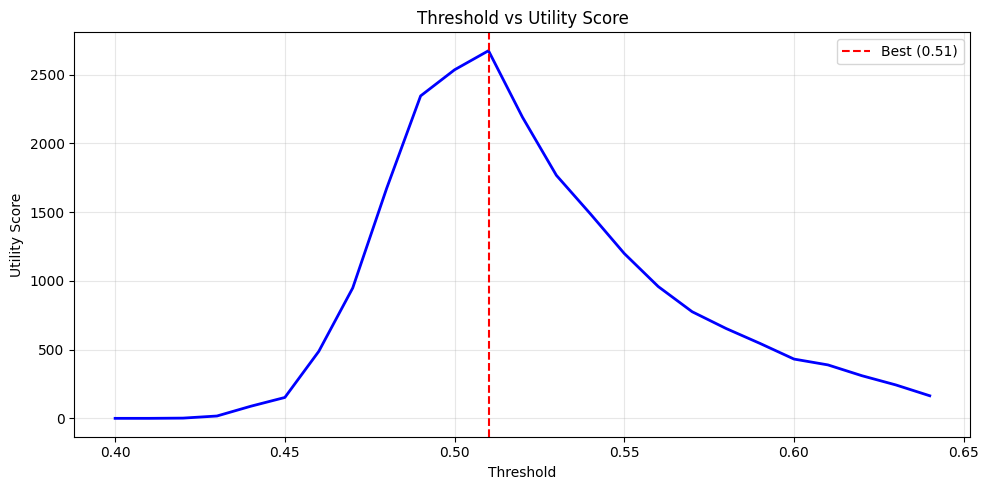

In [15]:
# Threshold Optimization
print("=" * 60 + "\nThreshold Optimization\n" + "=" * 60)

best_ensemble_prob = (mlp_prob_resp3 + xgb_prob) / 2
thresholds = np.arange(0.40, 0.65, 0.01)
results_thresh = [{'threshold': t, 'utility': utility_score(val_df['date'].values, val_df['weight'].values, 
                   val_df['resp'].values, (best_ensemble_prob >= t).astype(int))} for t in thresholds]

results_thresh_df = pd.DataFrame(results_thresh)
best_thresh = results_thresh_df.loc[results_thresh_df['utility'].idxmax(), 'threshold']
print(f"Best threshold: {best_thresh:.2f}")

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(results_thresh_df['threshold'], results_thresh_df['utility'], 'b-', linewidth=2)
ax.axvline(x=best_thresh, color='red', linestyle='--', label=f'Best ({best_thresh:.2f})')
ax.set_xlabel('Threshold'); ax.set_ylabel('Utility Score')
ax.set_title('Threshold vs Utility Score'); ax.legend(); ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'plots', 'threshold_optimization.png'), dpi=150)
plt.show()

### 8.2 Final Comparison (4 Strategies)

1. **Best Ensemble**: Best XGBoost + Best AE-MLP (resp_3), t=0.51
2. **Baseline Ensemble**: Original author (5targets + XGBoost), t=0.51
3. **Best XGBoost**: t=0.50
4. **Best AE-MLP**: resp_3, t=0.50

In [28]:
print("\n" + "=" * 70 + "\nFINAL COMPARISON\n" + "=" * 70)

# Calculate metrics
auc_xgb = roc_auc_score(y_true, xgb_prob)
util_xgb_t50 = utility_score(val_df['date'].values, val_df['weight'].values, val_df['resp'].values, (xgb_prob >= 0.50).astype(int))

auc_mlp_resp3 = roc_auc_score(y_true, mlp_prob_resp3)
util_mlp_resp3_t50 = utility_score(val_df['date'].values, val_df['weight'].values, val_df['resp'].values, (mlp_prob_resp3 >= 0.50).astype(int))

baseline_ensemble_prob = (mlp_prob_5targets + xgb_prob) / 2
auc_baseline_ensemble = roc_auc_score(y_true, baseline_ensemble_prob)
util_baseline_ensemble = utility_score(val_df['date'].values, val_df['weight'].values, val_df['resp'].values, (baseline_ensemble_prob >= 0.51).astype(int))

best_ensemble_prob = (mlp_prob_resp3 + xgb_prob) / 2
auc_best_ensemble = roc_auc_score(y_true, best_ensemble_prob)
util_best_ensemble = utility_score(val_df['date'].values, val_df['weight'].values, val_df['resp'].values, (best_ensemble_prob >= 0.51).astype(int))

final_comparison = [
    {'Strategy': 'Best Ensemble (XGB + resp_3 MLP, t=0.51)', 'AUC': auc_best_ensemble, 'Utility': util_best_ensemble, 'Threshold': 0.51},
    {'Strategy': 'Baseline Ensemble (Original, t=0.51)', 'AUC': auc_baseline_ensemble, 'Utility': util_baseline_ensemble, 'Threshold': 0.51},
    {'Strategy': 'Best XGBoost (t=0.50)', 'AUC': auc_xgb, 'Utility': util_xgb_t50, 'Threshold': 0.50},
    {'Strategy': 'Best AE-MLP (resp_3, t=0.50)', 'AUC': auc_mlp_resp3, 'Utility': util_mlp_resp3_t50, 'Threshold': 0.50},
]

final_df = pd.DataFrame(final_comparison).sort_values('Utility', ascending=False).reset_index(drop=True)
final_df['vs Baseline'] = final_df['Utility'] - util_baseline_ensemble
final_df['Gain %'] = (final_df['Utility'] / util_baseline_ensemble - 1) * 100

print("\n" + "=" * 70 + "\nRESULTS\n" + "=" * 70)
print(final_df[['Strategy', 'AUC', 'Utility', 'Threshold', 'vs Baseline', 'Gain %']].to_string(index=False))

best_row = final_df.iloc[0]
print(f"\n" + "=" * 70)
print(f"BEST STRATEGY: {best_row['Strategy']}")
print(f"   AUC: {best_row['AUC']:.5f}")
print(f"   Utility Score: {best_row['Utility']:.2f}")
print(f"   vs Baseline: {best_row['vs Baseline']:+.2f} ({best_row['Gain %']:+.2f}%)")
print("=" * 70)


FINAL COMPARISON

RESULTS
                                Strategy      AUC     Utility  Threshold  vs Baseline     Gain %
Best Ensemble (XGB + resp_3 MLP, t=0.51) 0.536139 2674.927451       0.51   287.194659  12.027923
    Baseline Ensemble (Original, t=0.51) 0.537231 2387.732793       0.51     0.000000   0.000000
            Best AE-MLP (resp_3, t=0.50) 0.529366 2227.273909       0.50  -160.458883  -6.720136
                   Best XGBoost (t=0.50) 0.534811 2019.959542       0.50  -367.773251 -15.402613

BEST STRATEGY: Best Ensemble (XGB + resp_3 MLP, t=0.51)
   AUC: 0.53614
   Utility Score: 2674.93
   vs Baseline: +287.19 (+12.03%)


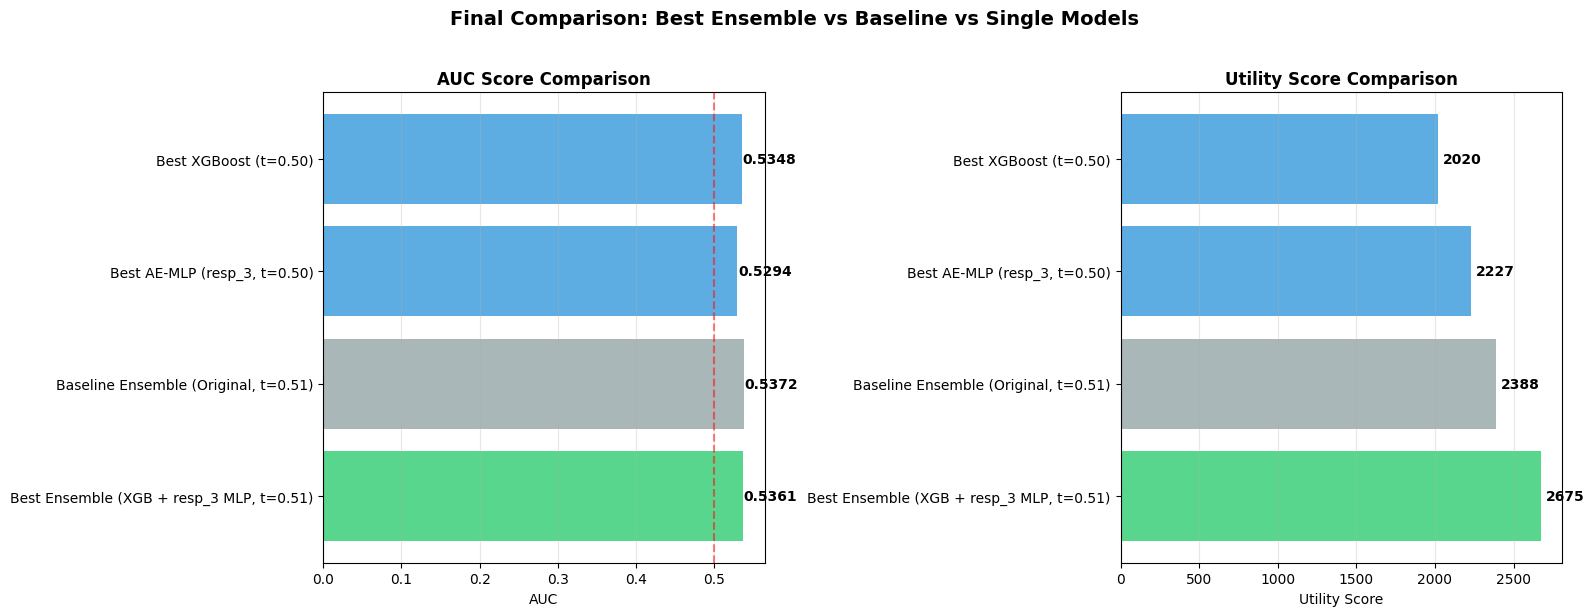


Results saved.


In [29]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

colors = ['#2ecc71' if i == 0 else '#95a5a6' if 'Baseline' in final_df.iloc[i]['Strategy'] else '#3498db' 
          for i in range(len(final_df))]

ax1 = axes[0]
y_pos = range(len(final_df))
ax1.barh(y_pos, final_df['AUC'], color=colors, alpha=0.8)
ax1.set_yticks(y_pos); ax1.set_yticklabels(final_df['Strategy'], fontsize=10)
ax1.set_xlabel('AUC'); ax1.set_title('AUC Score Comparison', fontweight='bold')
ax1.axvline(x=0.5, color='red', linestyle='--', alpha=0.5)
for i, v in enumerate(final_df['AUC']): ax1.text(v + 0.001, i, f'{v:.4f}', va='center', fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

ax2 = axes[1]
ax2.barh(y_pos, final_df['Utility'], color=colors, alpha=0.8)
ax2.set_yticks(y_pos); ax2.set_yticklabels(final_df['Strategy'], fontsize=10)
ax2.set_xlabel('Utility Score'); ax2.set_title('Utility Score Comparison', fontweight='bold')
for i, v in enumerate(final_df['Utility']): ax2.text(v + 30, i, f'{v:.0f}', va='center', fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

plt.suptitle('Final Comparison: Best Ensemble vs Baseline vs Single Models', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'plots', 'final_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

final_df.to_csv(os.path.join(OUTPUT_DIR, 'final_comparison_results.csv'), index=False)
print(f"\nResults saved.")

## 9. Summary

### Key Findings

**1. AE-MLP Target Selection**:
- `resp_3` (single target) outperforms `5targets` (original author method)
- Reason: Same target as XGBoost → more consistent signal for ensemble

**2. XGBoost Configuration**:
- Baseline (depth=11, min_child_weight=1) performs best
- Conservative/Aggressive configs reduce performance

**3. Best Strategy**:
- **Best Ensemble** = Best XGBoost + Best AE-MLP (resp_3)
- **Threshold** = 0.51

### Techniques Used
1. **PurgedGroupTimeSeriesSplit**: Time series CV with gap to prevent data leakage
2. **Denoising Autoencoder**: Noise injection for robust feature learning
3. **Black Swan Detection**: IQR method to identify extreme market days
4. **Model Ensemble**: AE-MLP + XGBoost averaging

### Potential Improvements
- Feature engineering (rolling stats, time features)
- Alternative ensemble methods (stacking, weighted average)
- Deep learning architectures (Transformer, LSTM)